In [1]:
#Imports
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import tensorflow as tf
from tensorflow import keras

import random

#Create Gym
from gym import wrappers
envCartPole = gym.make('CartPole-v1')
envCartPole.seed(50) #Set the seed to keep the environment consistent across runs

[50]

In [3]:
tmp_array = []
for i in range(100):
    tmp_array.append(i)
    
#Add 10 to each element
tmp_array = np.array(tmp_array) + 10
print(tmp_array)

[ 10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27
  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45
  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 109]


In [4]:
#Global Variables
EPISODES = 500
TRAIN_END = 0

In [5]:
#Hyper Parameters
def discount_rate(): #Gamma
    return 0.95

def learning_rate(): #Alpha
    return 0.001

def batch_size(): #Size of the batch used in the experience replay
    return 24

The following class is the deep Q-network that is built using the neural network code from Keras.
init:
     This creates the class and sets the local parameters.
     I use a deque for the local memory to hold the experiences and a keras model for the NN.
build_model(self):
     This builds the NN. I am using sequential model. Each of the layers are Dense despite the fact the document talks about using Convolution. But, they are only using that because they need to convert pixels and I already have numbers.
     I am using an input layer(4), 24 neuron layer, 24 neuron layer, and an output layer(2).
     For calculating the loss I am using mean squared error.
     For an optimizer I am using Adam. It is a variant of gradient descent 
action(self,state):
     This generates the action.
     Explore: I am using the epsilon like previous lessons.
     Exploit: I use the NN to grab the 2 possible actions and then grab the argmax to find the better one
test_action(self,state):
     This generates the action when I am testing. I want to 100% exploit
store(self, state, action, reward, nstate, done):
     This places the observables in memory
experience_replay(self, batch_size):
     This is where the training occurs. We grab the sample batches and then use the NN to predict the optimal action.

In [6]:
class DeepQNetwork():
    def __init__(self, states, actions, alpha, gamma, epsilon,epsilon_min, epsilon_decay):
        self.nS = states
        self.nA = actions
        self.memory = deque([], maxlen=2500)
        self.alpha = alpha
        self.gamma = gamma
        #Explore/Exploit
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.model = self.build_model()
        self.loss = []
        
    def build_model(self):
        model = keras.Sequential() #linear stack of layers https://keras.io/models/sequential/
        model.add(keras.layers.Dense(24, input_dim=self.nS, activation='relu')) #[Input] -> Layer 1
        #   Dense: Densely connected layer https://keras.io/layers/core/
        #   24: Number of neurons
        #   input_dim: Number of input variables
        #   activation: Rectified Linear Unit (relu) ranges >= 0
        model.add(keras.layers.Dense(24, activation='relu')) #Layer 2 -> 3
        model.add(keras.layers.Dense(self.nA, activation='linear')) #Layer 3 -> [output]
        #   Size has to match the output (different actions)
        #   Linear activation on the last layer
        model.compile(loss='mean_squared_error', #Loss function: Mean Squared Error
                      optimizer=keras.optimizers.Adam(lr=self.alpha)) #Optimaizer: Adam (Feel free to check other options)
        return model

    def action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.nA) #Explore
        action_vals = self.model.predict(state) #Exploit: Use the NN to predict the correct action from this state
        return np.argmax(action_vals[0])

    def test_action(self, state): #Exploit
        action_vals = self.model.predict(state)
        return np.argmax(action_vals[0])

    def store(self, state, action, reward, nstate, done):
        #Store the experience in memory
        self.memory.append( (state, action, reward, nstate, done) )

    def experience_replay(self, batch_size):
        #Execute the experience replay
        minibatch = random.sample( self.memory, batch_size ) #Randomly sample from memory

        #Convert to numpy for speed by vectorization
        x = []
        y = []
        np_array = np.array(minibatch)
        st = np.zeros((0,self.nS)) #States
        nst = np.zeros( (0,self.nS) )#Next States
        for i in range(len(np_array)): #Creating the state and next state np arrays
            st = np.append( st, np_array[i,0], axis=0)
            nst = np.append( nst, np_array[i,3], axis=0)
        st_predict = self.model.predict(st) #Here is the speedup! I can predict on the ENTIRE batch
        nst_predict = self.model.predict(nst)
        index = 0
        for state, action, reward, nstate, done in minibatch:
            x.append(state)
            #Predict from state
            nst_action_predict_model = nst_predict[index]
            if done == True: #Terminal: Just assign reward much like {* (not done) - QB[state][action]}
                target = reward
            else:   #Non terminal
                target = reward + self.gamma * np.amax(nst_action_predict_model)
            target_f = st_predict[index]
            target_f[action] = target
            y.append(target_f)
            index += 1
        #Reshape for Keras Fit
        x_reshape = np.array(x).reshape(batch_size,self.nS)
        y_reshape = np.array(y)
        epoch_count = 1 #Epochs is the number or iterations
        hist = self.model.fit(x_reshape, y_reshape, epochs=epoch_count, verbose=0)
        #Graph Losses
        for i in range(epoch_count):
            self.loss.append( hist.history['loss'][i] )
        #Decay Epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [7]:
#Create the agent
nS = envCartPole.observation_space.shape[0] #This is only 4
nA = envCartPole.action_space.n #Actions
dqn = DeepQNetwork(nS, nA, learning_rate(), discount_rate(), 1, 0.001, 0.995 )

batch_size = batch_size()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [8]:
#Training
rewards = [] #Store rewards for graphing
epsilons = [] # Store the Explore/Exploit
TEST_Episodes = 0
for e in range(EPISODES):
    state = envCartPole.reset()
    state = np.reshape(state, [1, nS]) # Resize to store in memory to pass to .predict
    tot_rewards = 0
    for time in range(210): #200 is when you "solve" the game. This can continue forever as far as I know
        action = dqn.action(state)
        nstate, reward, done, _ = envCartPole.step(action)
        nstate = np.reshape(nstate, [1, nS])
        tot_rewards += reward
        dqn.store(state, action, reward, nstate, done) # Resize to store in memory to pass to .predict
        state = nstate
        #done: CartPole fell. 
        #time == 209: CartPole stayed upright
        if done or time == 209:
            rewards.append(tot_rewards)
            epsilons.append(dqn.epsilon)
            print("episode: {}/{}, score: {}, e: {}"
                  .format(e, EPISODES, tot_rewards, dqn.epsilon))
            break
        #Experience Replay
        if len(dqn.memory) > batch_size:
            dqn.experience_replay(batch_size)
    #If our current NN passes we are done
    #I am going to use the last 5 runs
    if len(rewards) > 5 and np.average(rewards[-5:]) > 195:
        #Set the rest of the EPISODES for testing
        TEST_Episodes = EPISODES - e
        TRAIN_END = e
        break

episode: 0/500, score: 20.0, e: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


episode: 1/500, score: 25.0, e: 0.9046104802746175
episode: 2/500, score: 13.0, e: 0.851801859600347
episode: 3/500, score: 29.0, e: 0.7402609576967045
episode: 4/500, score: 13.0, e: 0.697046600835495
episode: 5/500, score: 14.0, e: 0.653073201944699
episode: 6/500, score: 14.0, e: 0.6118738784280476
episode: 7/500, score: 15.0, e: 0.5704072587541458
episode: 8/500, score: 11.0, e: 0.5425201222922789
episode: 9/500, score: 15.0, e: 0.5057535983897912
episode: 10/500, score: 13.0, e: 0.47622912292284103
episode: 11/500, score: 10.0, e: 0.45522245551230495
episode: 12/500, score: 16.0, e: 0.4222502236424958
episode: 13/500, score: 11.0, e: 0.4016064652978155
episode: 14/500, score: 12.0, e: 0.3800621177172763
episode: 15/500, score: 12.0, e: 0.3596735257153405
episode: 16/500, score: 10.0, e: 0.3438081748424137
episode: 17/500, score: 10.0, e: 0.32864265128599696
episode: 18/500, score: 11.0, e: 0.3125753549412418
episode: 19/500, score: 9.0, e: 0.30028896908517405
episode: 20/500, scor

In [9]:
#Test the agent that was trained
#   In this section we ALWAYS use exploit don't train any more
for e_test in range(TEST_Episodes):
    state = envCartPole.reset()
    state = np.reshape(state, [1, nS])
    tot_rewards = 0
    for t_test in range(210):
        action = dqn.test_action(state)
        nstate, reward, done, _ = envCartPole.step(action)
        nstate = np.reshape( nstate, [1, nS])
        tot_rewards += reward
        #DON'T STORE ANYTHING DURING TESTING
        state = nstate
        #done: CartPole fell. 
        #t_test == 209: CartPole stayed upright
        if done or t_test == 209: 
            rewards.append(tot_rewards)
            epsilons.append(0) #We are doing full exploit
            print("episode: {}/{}, score: {}, e: {}"
                  .format(e_test, TEST_Episodes, tot_rewards, 0))
            break;

episode: 0/406, score: 210.0, e: 0
episode: 1/406, score: 210.0, e: 0
episode: 2/406, score: 65.0, e: 0
episode: 3/406, score: 210.0, e: 0
episode: 4/406, score: 210.0, e: 0
episode: 5/406, score: 210.0, e: 0
episode: 6/406, score: 118.0, e: 0
episode: 7/406, score: 99.0, e: 0
episode: 8/406, score: 210.0, e: 0
episode: 9/406, score: 210.0, e: 0
episode: 10/406, score: 210.0, e: 0
episode: 11/406, score: 210.0, e: 0
episode: 12/406, score: 210.0, e: 0
episode: 13/406, score: 210.0, e: 0
episode: 14/406, score: 210.0, e: 0
episode: 15/406, score: 115.0, e: 0
episode: 16/406, score: 210.0, e: 0
episode: 17/406, score: 210.0, e: 0
episode: 18/406, score: 210.0, e: 0
episode: 19/406, score: 210.0, e: 0
episode: 20/406, score: 210.0, e: 0
episode: 21/406, score: 210.0, e: 0
episode: 22/406, score: 210.0, e: 0
episode: 23/406, score: 210.0, e: 0
episode: 24/406, score: 210.0, e: 0
episode: 25/406, score: 210.0, e: 0
episode: 26/406, score: 210.0, e: 0
episode: 27/406, score: 69.0, e: 0
episo

Results
Here is a graph of the results. If everything was done correctly you should see the rewards over the red line.
Black: This is the 100 episode rolling average
Red: This is the "solved" line at 195
Blue: This is the reward for each episode
Green: This is the value of epsilon scaled by 200
Yellow: This is where the tests started.

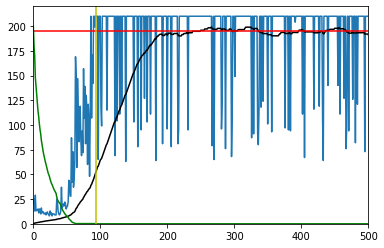

In [10]:
rolling_average = np.convolve(rewards, np.ones(100)/100)

plt.plot(rewards)
plt.plot(rolling_average, color='black')
plt.axhline(y=195, color='r', linestyle='-') #Solved Line
#Scale Epsilon (0.001 - 1.0) to match reward (0 - 200) range
eps_graph = [200*x for x in epsilons]
plt.plot(eps_graph, color='g', linestyle='-')
#Plot the line where TESTING begins
plt.axvline(x=TRAIN_END, color='y', linestyle='-')
plt.xlim( (0,EPISODES) )
plt.ylim( (0,220) )
plt.show()


envCartPole.close()